# Workshop 10 - Training Neural Networks (Learning rate scheduling and optimisers)

Code for workshop 10.  This will use Keras (within tensorflow v2)

Modified by Hu Wang

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

In [2]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


## Load data
We will use MNIST, which is a set of small images (28x28) that contain 10 digits - see below for class names and an example image.

In [3]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
7


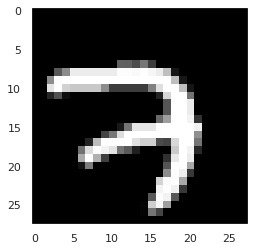

In [5]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around with the data 
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

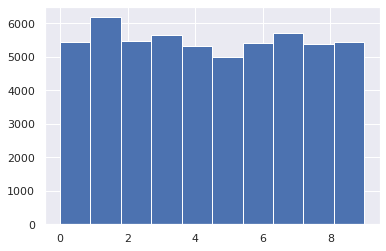

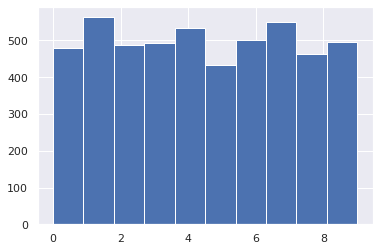

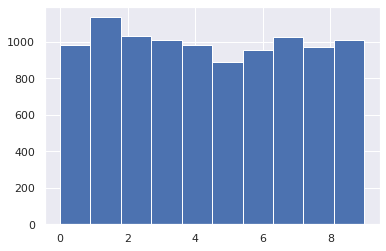

In [6]:
# Let's look at the distribution of labels in the training, validation and test sets
plt.hist(y_train)
plt.show()
plt.hist(y_valid)
plt.show()
plt.hist(y_test)
plt.show()

## Simple Neural Network Code with Keras

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [12]:
# Some key parameters
n_train = 300
n_valid = 100
# Define the number and size of hidden units
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
#actfn = "relu"
actfn = "elu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 20

In [13]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [14]:
# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by replacing the Flatten and Dense lines with
#   model.add(keras.layers.Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate a single output per filter 
#  which requires the convolution to be "valid" and not "same"

In [15]:
def model_dense_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [16]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [18]:
# Early stopping callback - this is executed when fitting and will stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) 

In [19]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [20]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
10/10 [==============================] - 1s 55ms/step - loss: 2.3203 - accuracy: 0.0733 - val_loss: 2.2961 - val_accuracy: 0.1600
Epoch 2/20
10/10 [==============================] - 0s 32ms/step - loss: 2.2952 - accuracy: 0.1033 - val_loss: 2.2755 - val_accuracy: 0.1900
Epoch 3/20
10/10 [==============================] - 0s 29ms/step - loss: 2.2739 - accuracy: 0.1667 - val_loss: 2.2560 - val_accuracy: 0.2700
Epoch 4/20
10/10 [==============================] - 0s 28ms/step - loss: 2.2516 - accuracy: 0.2067 - val_loss: 2.2357 - val_accuracy: 0.3200
Epoch 5/20
10/10 [==============================] - 0s 30ms/step - loss: 2.2298 - accuracy: 0.2633 - val_loss: 2.2148 - val_accuracy: 0.3200
Epoch 6/20
10/10 [==============================] - 0s 28ms/step - loss: 2.2062 - accuracy: 0.2767 - val_loss: 2.1909 - val_accuracy: 0.3200
Epoch 7/20
10/10 [==============================] - 0s 29ms/step - loss: 2.1793 - accuracy: 0.2567 - val_loss: 2.1648 - val_accuracy: 0.3800
Epoch 8/20
10

In [21]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

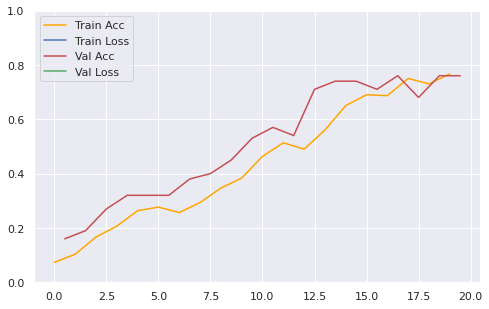

In [22]:
plot_history(history)

# Manually exploring the learning rate



Epoch 1/20
10/10 [==============================] - 1s 45ms/step - loss: 2.2439 - accuracy: 0.1933 - val_loss: 2.0936 - val_accuracy: 0.3200
Epoch 2/20
10/10 [==============================] - 0s 29ms/step - loss: 1.8483 - accuracy: 0.5000 - val_loss: 1.5092 - val_accuracy: 0.5600
Epoch 3/20
10/10 [==============================] - 0s 30ms/step - loss: 1.1705 - accuracy: 0.6300 - val_loss: 0.8896 - val_accuracy: 0.7700
Epoch 4/20
10/10 [==============================] - 0s 28ms/step - loss: 0.6719 - accuracy: 0.8100 - val_loss: 0.5914 - val_accuracy: 0.8500
Epoch 5/20
10/10 [==============================] - 0s 29ms/step - loss: 0.4287 - accuracy: 0.8767 - val_loss: 0.5414 - val_accuracy: 0.8500
Epoch 6/20
10/10 [==============================] - 0s 30ms/step - loss: 0.3709 - accuracy: 0.8833 - val_loss: 0.4953 - val_accuracy: 0.8600
Epoch 7/20
10/10 [==============================] - 0s 29ms/step - loss: 0.2943 - accuracy: 0.9133 - val_loss: 0.3794 - val_accuracy: 0.9100
Epoch 8/20
10

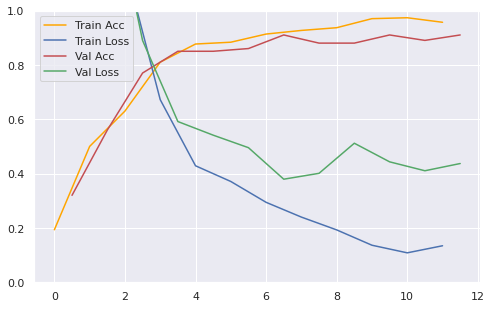

Epoch 1/20
10/10 [==============================] - 1s 46ms/step - loss: 2.3054 - accuracy: 0.0733 - val_loss: 2.3092 - val_accuracy: 0.0300
Epoch 2/20
10/10 [==============================] - 0s 29ms/step - loss: 2.3032 - accuracy: 0.0733 - val_loss: 2.3073 - val_accuracy: 0.0300
Epoch 3/20
10/10 [==============================] - 0s 28ms/step - loss: 2.3013 - accuracy: 0.0733 - val_loss: 2.3055 - val_accuracy: 0.0200
Epoch 4/20
10/10 [==============================] - 0s 28ms/step - loss: 2.2993 - accuracy: 0.0733 - val_loss: 2.3035 - val_accuracy: 0.0200
Epoch 5/20
10/10 [==============================] - 0s 29ms/step - loss: 2.2972 - accuracy: 0.0800 - val_loss: 2.3018 - val_accuracy: 0.0200
Epoch 6/20
10/10 [==============================] - 0s 28ms/step - loss: 2.2951 - accuracy: 0.0800 - val_loss: 2.3001 - val_accuracy: 0.0200
Epoch 7/20
10/10 [==============================] - 0s 30ms/step - loss: 2.2933 - accuracy: 0.0767 - val_loss: 2.2983 - val_accuracy: 0.0300
Epoch 8/20
10

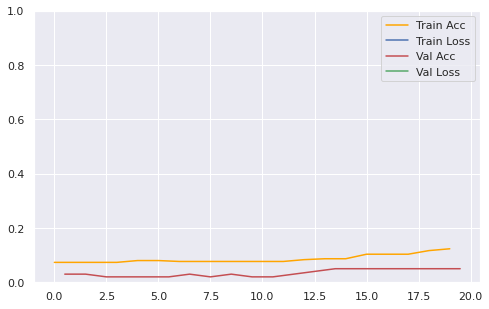

Epoch 1/20
10/10 [==============================] - 1s 78ms/step - loss: 2.2935 - accuracy: 0.0700 - val_loss: 2.2868 - val_accuracy: 0.0600
Epoch 2/20
10/10 [==============================] - 1s 52ms/step - loss: 2.2932 - accuracy: 0.0700 - val_loss: 2.2865 - val_accuracy: 0.0600
Epoch 3/20
10/10 [==============================] - 0s 31ms/step - loss: 2.2930 - accuracy: 0.0733 - val_loss: 2.2863 - val_accuracy: 0.0600
Epoch 4/20
10/10 [==============================] - 0s 30ms/step - loss: 2.2928 - accuracy: 0.0733 - val_loss: 2.2860 - val_accuracy: 0.0600
Epoch 5/20
10/10 [==============================] - 0s 30ms/step - loss: 2.2925 - accuracy: 0.0733 - val_loss: 2.2858 - val_accuracy: 0.0600
Epoch 6/20
10/10 [==============================] - 0s 30ms/step - loss: 2.2923 - accuracy: 0.0733 - val_loss: 2.2856 - val_accuracy: 0.0600
Epoch 7/20
10/10 [==============================] - 0s 29ms/step - loss: 2.2921 - accuracy: 0.0733 - val_loss: 2.2854 - val_accuracy: 0.0600
Epoch 8/20
10

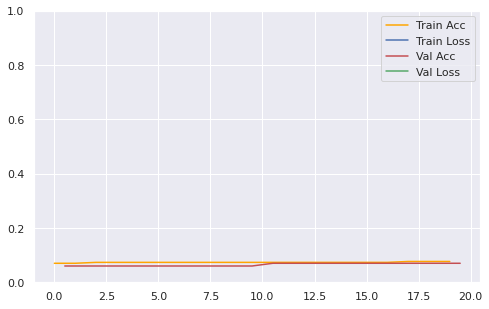

[[0.1, 0.9100000262260437], [0.001, 0.05000000074505806], [0.0001, 0.07000000029802322]]


In [23]:
# Learning rate
res=[]
for lr in [10, 0.1, 0.01]:
    valacc, history, discard = do_all(hiddensizes, actfn, optimizer, lr*learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[lr*learningrate,valacc]]
print(res)

Text(0, 0.5, 'Val Accuracy')

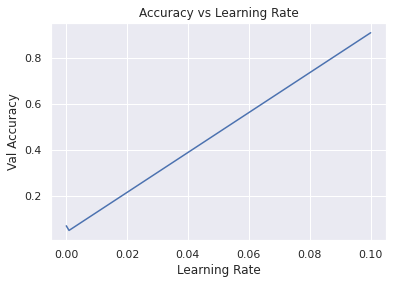

In [24]:
res=np.array(res)
plt.plot(res[:,0],res[:,1])
plt.title('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Val Accuracy')

In [28]:
hiddensizes[:1]

[16]

Epoch 1/20
10/10 [==============================] - 1s 40ms/step - loss: 2.2809 - accuracy: 0.1600 - val_loss: 2.2578 - val_accuracy: 0.1700
Epoch 2/20
10/10 [==============================] - 0s 23ms/step - loss: 2.2238 - accuracy: 0.2667 - val_loss: 2.2061 - val_accuracy: 0.2400
Epoch 3/20
10/10 [==============================] - 0s 23ms/step - loss: 2.1655 - accuracy: 0.3333 - val_loss: 2.1458 - val_accuracy: 0.3200
Epoch 4/20
10/10 [==============================] - 1s 62ms/step - loss: 2.0954 - accuracy: 0.3967 - val_loss: 2.0761 - val_accuracy: 0.4200
Epoch 5/20
10/10 [==============================] - 1s 52ms/step - loss: 2.0148 - accuracy: 0.4633 - val_loss: 1.9939 - val_accuracy: 0.4900
Epoch 6/20
10/10 [==============================] - 1s 64ms/step - loss: 1.9181 - accuracy: 0.5667 - val_loss: 1.8866 - val_accuracy: 0.5600
Epoch 7/20
10/10 [==============================] - 0s 50ms/step - loss: 1.7979 - accuracy: 0.6267 - val_loss: 1.7580 - val_accuracy: 0.6600
Epoch 8/20
10

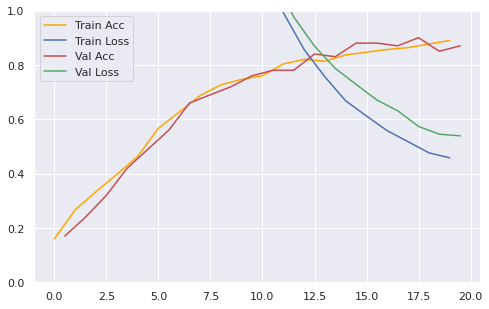

Epoch 1/20
10/10 [==============================] - 1s 42ms/step - loss: 2.2879 - accuracy: 0.1100 - val_loss: 2.2415 - val_accuracy: 0.2300
Epoch 2/20
10/10 [==============================] - 0s 27ms/step - loss: 2.2151 - accuracy: 0.2600 - val_loss: 2.1731 - val_accuracy: 0.3500
Epoch 3/20
10/10 [==============================] - 0s 28ms/step - loss: 2.1400 - accuracy: 0.3633 - val_loss: 2.0993 - val_accuracy: 0.5400
Epoch 4/20
10/10 [==============================] - 0s 30ms/step - loss: 2.0592 - accuracy: 0.4500 - val_loss: 2.0118 - val_accuracy: 0.6100
Epoch 5/20
10/10 [==============================] - 0s 27ms/step - loss: 1.9601 - accuracy: 0.5300 - val_loss: 1.9104 - val_accuracy: 0.7000
Epoch 6/20
10/10 [==============================] - 0s 26ms/step - loss: 1.8463 - accuracy: 0.5933 - val_loss: 1.7887 - val_accuracy: 0.7100
Epoch 7/20
10/10 [==============================] - 0s 26ms/step - loss: 1.7048 - accuracy: 0.6833 - val_loss: 1.6427 - val_accuracy: 0.7600
Epoch 8/20
10

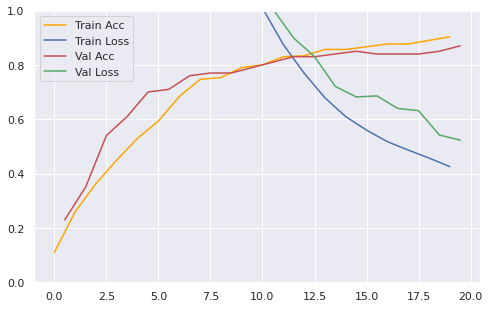

[[1, 0.8999999761581421], [2, 0.8700000047683716]]


In [25]:
# Number and size of hi dden units
# hiddensizes = [16, 32, 16]
res=[]
for n in [1, 2]:
    valacc, history, discard = do_all(hiddensizes[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[n,valacc]]
print(res)

In [ ]:
res=np.array(res)
plt.plot(res[:,0],res[:,1])
plt.title('Accuracy vs Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Val Accuracy')

# Exploring optimizers

Let us compare different optimizers on the same task.

Epoch 1/20
10/10 [==============================] - 1s 44ms/step - loss: 2.3268 - accuracy: 0.0533 - val_loss: 2.3112 - val_accuracy: 0.0600
Epoch 2/20
10/10 [==============================] - 0s 29ms/step - loss: 2.3071 - accuracy: 0.0667 - val_loss: 2.2932 - val_accuracy: 0.1600
Epoch 3/20
10/10 [==============================] - 0s 29ms/step - loss: 2.2887 - accuracy: 0.1167 - val_loss: 2.2750 - val_accuracy: 0.1700
Epoch 4/20
10/10 [==============================] - 0s 28ms/step - loss: 2.2711 - accuracy: 0.1333 - val_loss: 2.2597 - val_accuracy: 0.1900
Epoch 5/20
10/10 [==============================] - 0s 28ms/step - loss: 2.2544 - accuracy: 0.1500 - val_loss: 2.2415 - val_accuracy: 0.2000
Epoch 6/20
10/10 [==============================] - 0s 31ms/step - loss: 2.2367 - accuracy: 0.1800 - val_loss: 2.2240 - val_accuracy: 0.2400
Epoch 7/20
10/10 [==============================] - 0s 33ms/step - loss: 2.2161 - accuracy: 0.2100 - val_loss: 2.2032 - val_accuracy: 0.2200
Epoch 8/20
10

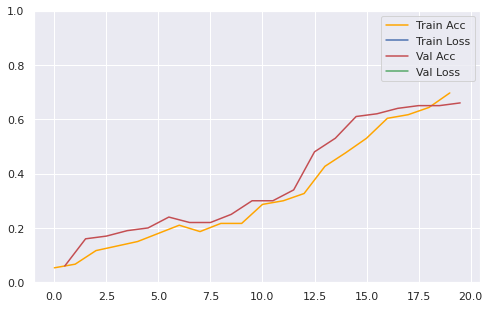

Epoch 1/20
10/10 [==============================] - 1s 47ms/step - loss: 2.2131 - accuracy: 0.2000 - val_loss: 2.0677 - val_accuracy: 0.5200
Epoch 2/20
10/10 [==============================] - 0s 31ms/step - loss: 1.9025 - accuracy: 0.5200 - val_loss: 1.6663 - val_accuracy: 0.7000
Epoch 3/20
10/10 [==============================] - 0s 33ms/step - loss: 1.4132 - accuracy: 0.6867 - val_loss: 1.1389 - val_accuracy: 0.7600
Epoch 4/20
10/10 [==============================] - 0s 31ms/step - loss: 0.9081 - accuracy: 0.7833 - val_loss: 0.7844 - val_accuracy: 0.8200
Epoch 5/20
10/10 [==============================] - 0s 31ms/step - loss: 0.6329 - accuracy: 0.8000 - val_loss: 0.6080 - val_accuracy: 0.8500
Epoch 6/20
10/10 [==============================] - 0s 32ms/step - loss: 0.5123 - accuracy: 0.8400 - val_loss: 0.5599 - val_accuracy: 0.8600
Epoch 7/20
10/10 [==============================] - 0s 30ms/step - loss: 0.4117 - accuracy: 0.8567 - val_loss: 0.4941 - val_accuracy: 0.8900
Epoch 8/20
10

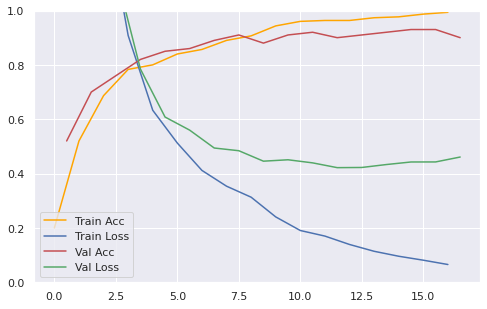

Epoch 1/20
10/10 [==============================] - 1s 45ms/step - loss: 2.1606 - accuracy: 0.2533 - val_loss: 1.8570 - val_accuracy: 0.5100
Epoch 2/20
10/10 [==============================] - 0s 30ms/step - loss: 1.5920 - accuracy: 0.6200 - val_loss: 1.2327 - val_accuracy: 0.7600
Epoch 3/20
10/10 [==============================] - 0s 29ms/step - loss: 0.9855 - accuracy: 0.7533 - val_loss: 0.7921 - val_accuracy: 0.8200
Epoch 4/20
10/10 [==============================] - 0s 29ms/step - loss: 0.6615 - accuracy: 0.8233 - val_loss: 0.6150 - val_accuracy: 0.8500
Epoch 5/20
10/10 [==============================] - 0s 30ms/step - loss: 0.5026 - accuracy: 0.8533 - val_loss: 0.4975 - val_accuracy: 0.8800
Epoch 6/20
10/10 [==============================] - 0s 31ms/step - loss: 0.3655 - accuracy: 0.9067 - val_loss: 0.5099 - val_accuracy: 0.8700
Epoch 7/20
10/10 [==============================] - 0s 29ms/step - loss: 0.3381 - accuracy: 0.9033 - val_loss: 0.5069 - val_accuracy: 0.8600
Epoch 8/20
10

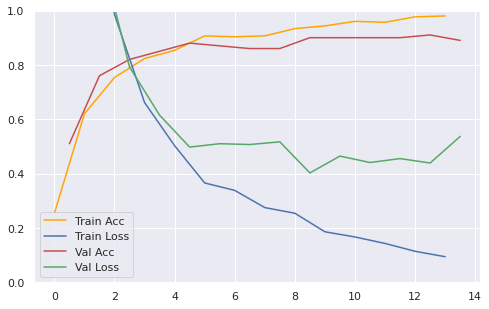

In [29]:
res=[]
for optimizer,lr in [[keras.optimizers.SGD,0.01], [keras.optimizers.Adam,0.001], [keras.optimizers.RMSprop,0.001]]:
    valacc, history, discard = do_all(hiddensizes, actfn, optimizer, lr, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[valacc]]

In [ ]:
res=np.array(res)
plt.plot(res[:,1])
plt.ylabel('Val Accuracy')

# Your Tasks

Which one has the best final classifier? 

Which one converges fastest? 

Which learning curve is the smoothest?

Which one would you choose?

# Exploring learning rate schedules

Let us compare different learning rate schedules on the same task.

Epoch 1/50
10/10 [==============================] - 1s 47ms/step - loss: 2.3276 - accuracy: 0.0767 - val_loss: 2.3182 - val_accuracy: 0.1300 - lr: 1.0000e-07
Epoch 2/50
10/10 [==============================] - 0s 31ms/step - loss: 2.3276 - accuracy: 0.0767 - val_loss: 2.3181 - val_accuracy: 0.1300 - lr: 1.5849e-07
Epoch 3/50
10/10 [==============================] - 0s 29ms/step - loss: 2.3276 - accuracy: 0.0767 - val_loss: 2.3181 - val_accuracy: 0.1300 - lr: 2.5119e-07
Epoch 4/50
10/10 [==============================] - 0s 30ms/step - loss: 2.3275 - accuracy: 0.0767 - val_loss: 2.3180 - val_accuracy: 0.1300 - lr: 3.9811e-07
Epoch 5/50
10/10 [==============================] - 0s 30ms/step - loss: 2.3274 - accuracy: 0.0767 - val_loss: 2.3178 - val_accuracy: 0.1300 - lr: 6.3096e-07
Epoch 6/50
10/10 [==============================] - 0s 29ms/step - loss: 2.3272 - accuracy: 0.0767 - val_loss: 2.3176 - val_accuracy: 0.1300 - lr: 1.0000e-06
Epoch 7/50
10/10 [==============================] - 

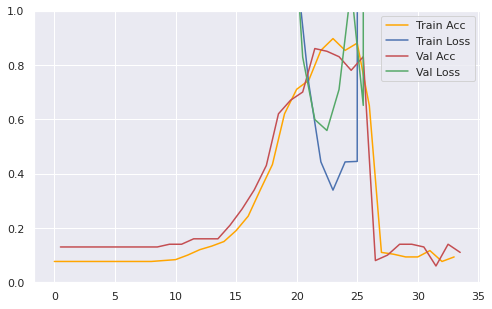

In [30]:
# Define scheduler functions
def exp_schedule(epoch):
    stretch=5
    return 0.0000001 * (10**(epoch/stretch))


early_stopping_cb2 = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True) 

# Run with piecewise_const learning rate scheduler
optimizer=keras.optimizers.Nadam
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exp_schedule)
valacc, history, discard = do_all(hiddensizes, actfn, optimizer, learningrate, 
                                           n_train, n_valid, 50, batch_size,
                                           [lr_scheduler,early_stopping_cb2])
plot_history(history)

In [31]:
maxlr=exp_schedule(22)
print(maxlr)

0.002511886431509582


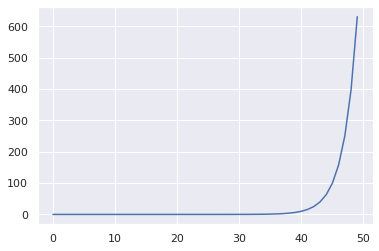

In [32]:
lrs=[]
for n in range(50):
        lrs = lrs + [exp_schedule(n)]
plt.plot(lrs)

Epoch 1/20
10/10 [==============================] - 1s 50ms/step - loss: 2.2513 - accuracy: 0.1700 - val_loss: 2.2202 - val_accuracy: 0.2800 - lr: 2.5119e-04
Epoch 2/20
10/10 [==============================] - 0s 30ms/step - loss: 2.1726 - accuracy: 0.2467 - val_loss: 2.0988 - val_accuracy: 0.5100 - lr: 4.7726e-04
Epoch 3/20
10/10 [==============================] - 0s 34ms/step - loss: 1.9844 - accuracy: 0.4967 - val_loss: 1.8038 - val_accuracy: 0.7300 - lr: 7.0333e-04
Epoch 4/20
10/10 [==============================] - 0s 32ms/step - loss: 1.5243 - accuracy: 0.7033 - val_loss: 1.1735 - val_accuracy: 0.7800 - lr: 9.2940e-04
Epoch 5/20
10/10 [==============================] - 0s 31ms/step - loss: 0.8828 - accuracy: 0.7800 - val_loss: 0.7342 - val_accuracy: 0.8300 - lr: 0.0012
Epoch 6/20
10/10 [==============================] - 0s 29ms/step - loss: 0.5409 - accuracy: 0.8633 - val_loss: 0.5704 - val_accuracy: 0.8400 - lr: 0.0014
Epoch 7/20
10/10 [==============================] - 0s 30ms/

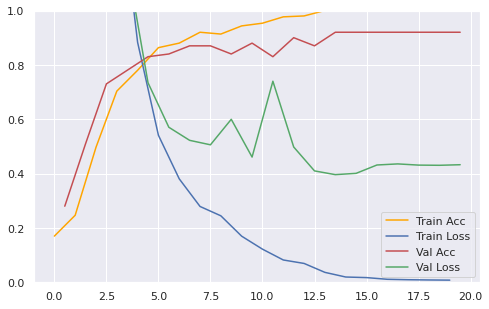

In [35]:
# Define scheduler functions
def OneCycleSchedule(epoch):
    maxepoch=20
    if epoch<maxepoch/2:
        lr=maxlr*(0.1 + (0.9*epoch/(maxepoch/2)))
    elif epoch<maxepoch:
        lr=maxlr*(1.9-0.9*epoch/(maxepoch/2))
    else:
        lr=0.1*maxlr
    return lr


early_stopping_cb3 = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True) 

# Run with piecewise_const learning rate scheduler
optimizer=keras.optimizers.Nadam
lr_scheduler2 = tf.keras.callbacks.LearningRateScheduler(OneCycleSchedule)
valacc, history, discard = do_all(hiddensizes, actfn, optimizer, learningrate, 
                                           n_train, n_valid, n_epochs, batch_size,
                                           [lr_scheduler2,early_stopping_cb3])
plot_history(history)

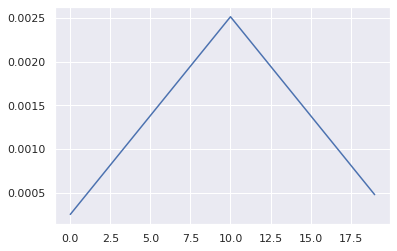

In [36]:
lrs=[]
for n in range(n_epochs):
        lrs = lrs + [OneCycleSchedule(n)]
plt.plot(lrs)

# Your Tasks: 

Write a new learning rate scheduler (copy from above and edit) that does a simple '1cycle' scheduling. Use the manual learning rate tests above *but with the Nadam optimizer* to choose a maximum learning rate. 

Manually experiment with the number of iterations for the upslope/down slope. 

Is the convergence faster than with a fixed learning rate?